In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os




In [6]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [38]:
 
def resize_all(src, pklname, include, width=150, height=None):
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})concrete images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file[:-4])
                    data['data'].append(im)
    return data
 


In [39]:
data_path = '/kaggle/input/concrete-and-pavement-crack-images'
os.listdir(data_path)

['Negative', 'Positive']

In [40]:
base_name = 'concrete_crack'
width = 80

# WE INCLUDE ALL FILE: WE HAVE QUITE SOME VARIETY OF ROCK WE WILL USE THEM ALL
include = os.listdir(data_path)
 
data = resize_all(src=data_path, pklname=base_name, width=width, include=include)

Negative
Positive


In [42]:
from collections import Counter
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
print('filename:', np.unique(data['filename']))
Counter(data['label'])

number of samples:  30000
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)concrete images in rgb
image shape:  (80, 80, 3)
labels: ['Negative' 'Positive']
filename: ['00001' '00002' '00003' ... '14998' '14999' '15000']


Counter({'Negative': 15000, 'Positive': 15000})

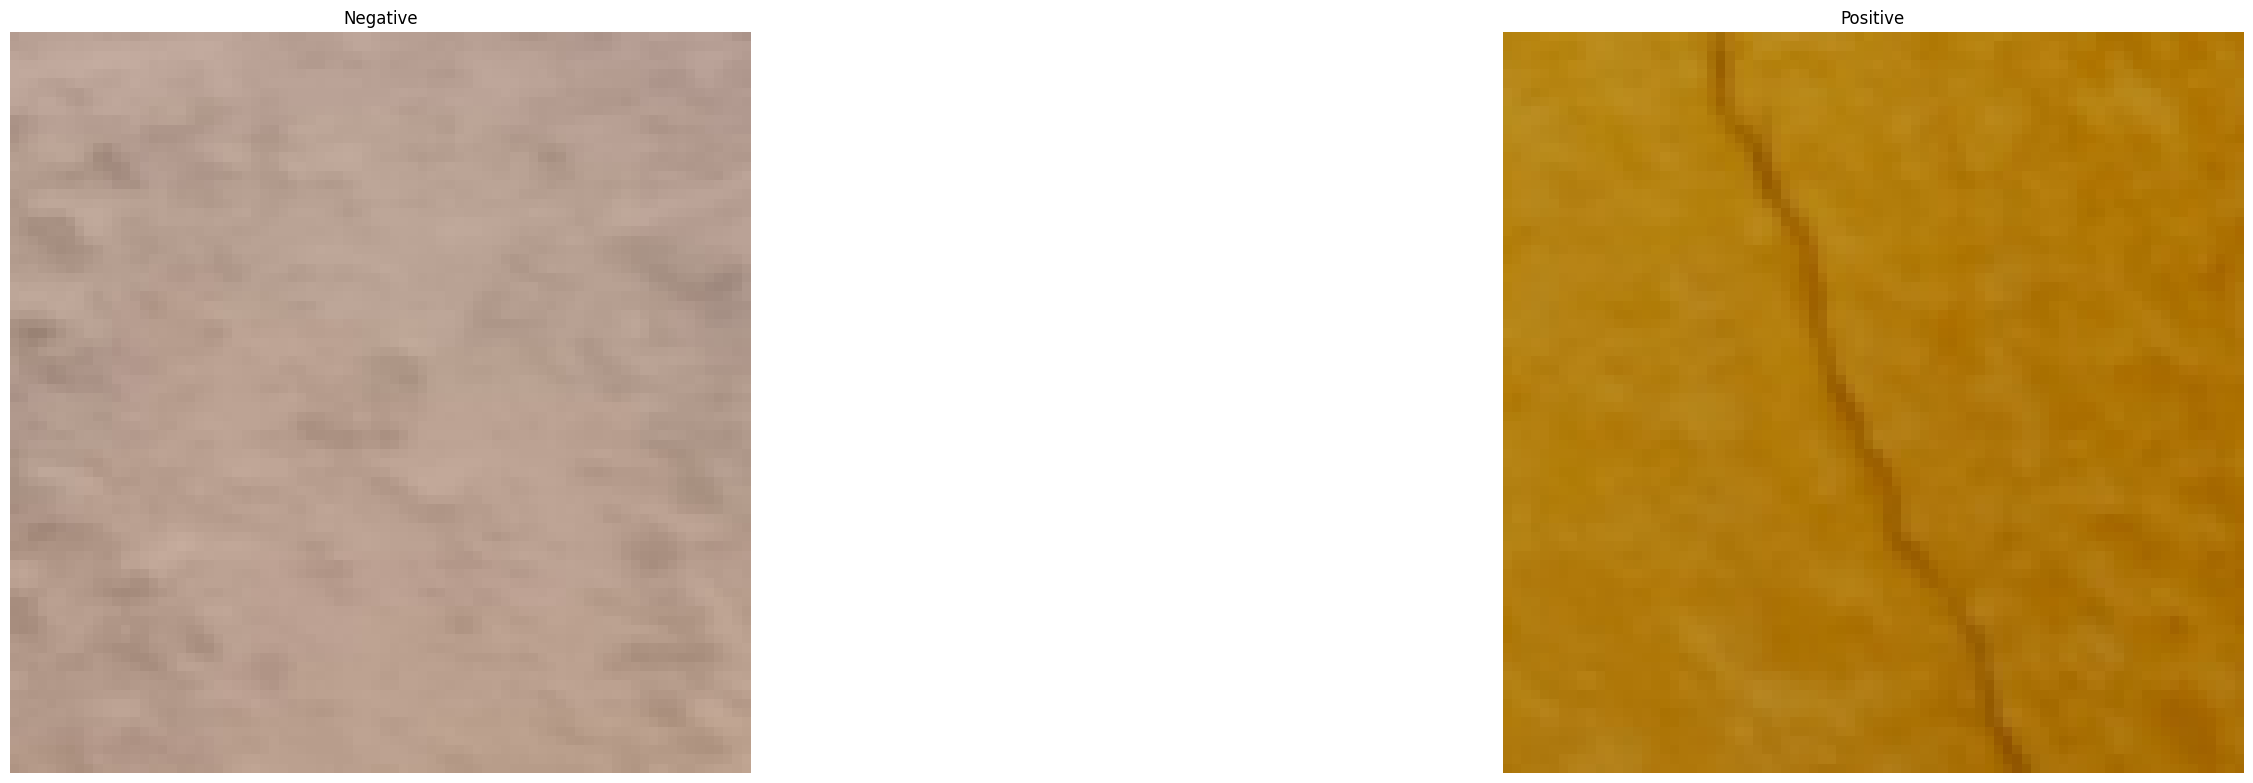

In [7]:
labels = np.unique(data['label'])


fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(30,8)
fig.tight_layout()
 

for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)


In [43]:
X = np.array(data['data'])
y = np.array(data['label'])

In [44]:
import joblib
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
    stratify=data['label']
)
joblib.dump(y_train, 'y_train_concrete_crack.pkl')
joblib.dump(y_test, 'y_test_concrete_crack.pkl')

['y_test_concrete_crack.pkl']

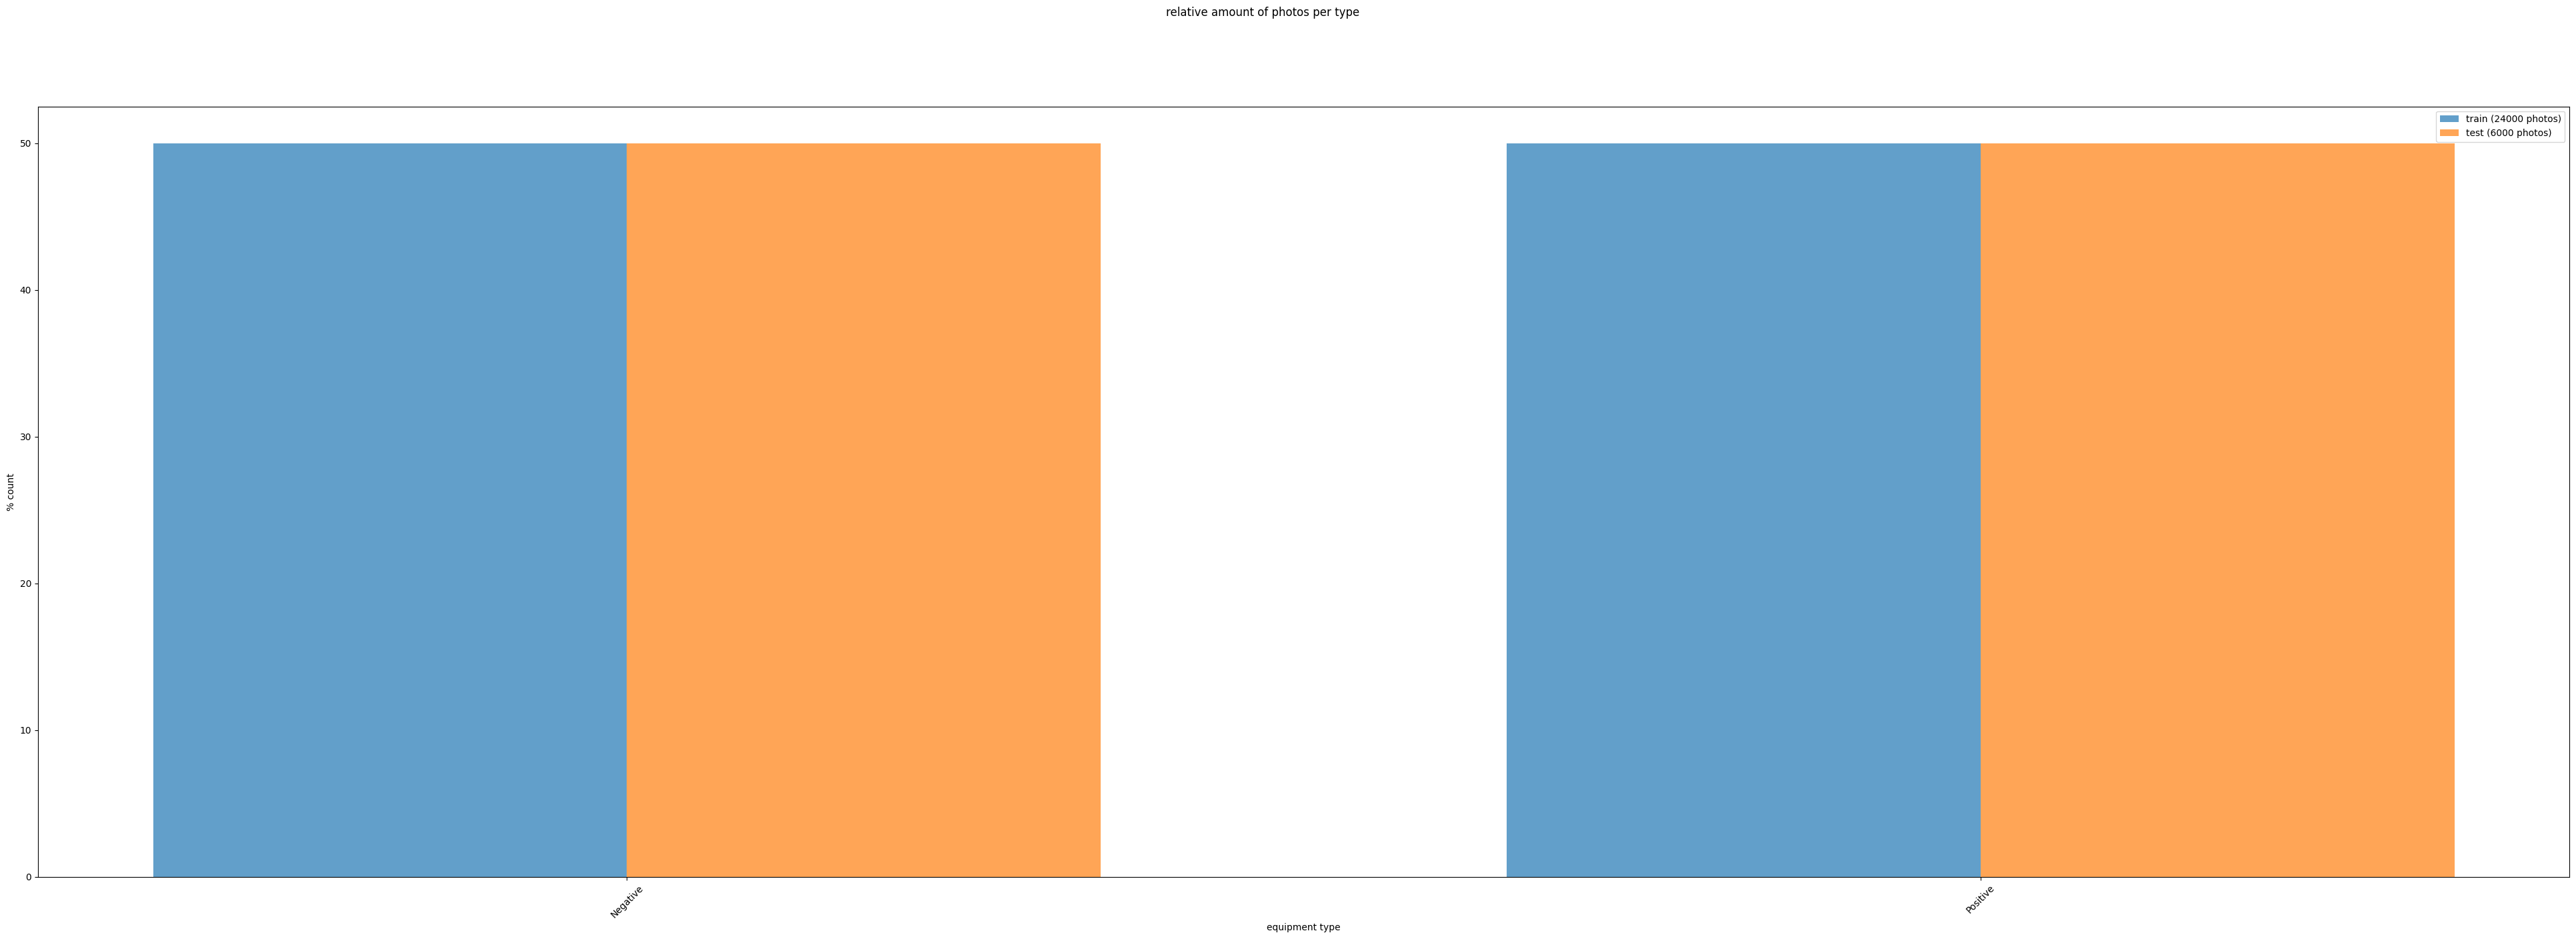

In [10]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
    
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
    
 
plt.figure(figsize=(49,15))
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    f'train ({len(y_train)} photos)', 
    f'test ({len(y_test)} photos)'
]);

In [9]:
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import skimage

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
#from sklearn.metrics import 
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        
        return self
 
    def transform(self, X, y=None):
        
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
 
    def __init__(self, y=None, pixels_per_cell=(8, 8),
                cells_per_block=(3, 3)):
        self.y = y
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        try: # parallel
            return np.array([hog(img, pixels_per_cell=self.pixels_per_cell, 
    cells_per_block=self.cells_per_block) for img in X])
        except:
            return np.array([hog(img, pixels_per_cell=self.pixels_per_cell, 
    cells_per_block=self.cells_per_block) for img in X])

In [10]:
full_pipeline = Pipeline([
    ("rgb_to_gray", RGB2GrayTransformer()),
    ("Hog_transformer", HogTransformer(pixels_per_cell=(8, 8),
                cells_per_block=(3, 3))),
    ("StandardScaler", StandardScaler()),
])
# joblib.dump(full_pipeline, 'pipeline.pkl')

In [13]:
# full_pipeline = Pipeline([
#     ("rgb_to_gray", RGB2GrayTransformer()),
#     ("Hog_transformer", HogTransformer(pixels_per_cell=(8, 8),
#                 cells_per_block=(3, 3))),
#     ("StandardScaler", StandardScaler()),
# ])
# full_pipeline_with_predevtor = Pipeline([
#     ("full_pipeline", full_pipeline),
#     ("sgd", SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)),
# ])
# full_pipeline_with_predevtor.fit(X_train, y_train)
# y_pred = full_pipeline_with_predevtor.predict(X_test)

In [14]:
# print(np.array(y_pred == y_test)[:25])
# print('')
# print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

In [15]:
train_trans_data = full_pipeline.fit_transform(X_train)
test_trans_data = full_pipeline.fit_transform(X_test)
trans_data = [train_trans_data, test_trans_data]
#joblib.dump(trans_data, 'trans_data_concrete_crack.pkl')

In [16]:
train_trans_data

array([[ 0.25646468, -1.02982764,  0.74599911, ..., -0.94258248,
        -0.75753043, -0.82774538],
       [ 0.64207763,  0.47902066, -0.29169691, ..., -0.74154217,
        -0.11778061, -0.30961181],
       [ 2.1739454 ,  1.33138018,  1.70308857, ...,  0.43007127,
         1.873077  ,  0.97059287],
       ...,
       [-1.64321017, -1.20502365, -0.26125754, ..., -0.69709149,
        -0.41309339,  0.30013443],
       [-0.67273582,  0.02153749, -0.3226091 , ..., -0.42650065,
        -0.50238252, -0.48491794],
       [-0.40877347, -0.89971455, -0.44689919, ..., -0.45644819,
        -0.15804705,  2.97456831]])

In [ ]:
sgd =  SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
linear_model = LogisticRegression()
svc_model = SVC()
ranf_model = RandomForestClassifier(random_state=42, n_jobs=-1
                                       , max_leaf_nodes=16 , n_estimators=500)

In [18]:

# ranf_model.fit(train_trans_data, y_train)
# y_pred = ranf_model.predict(test_trans_data)

# print(np.array(y_pred == y_test)[:25])
# print('')
# print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

In [19]:
# linear_model.fit(train_trans_data, y_train)
# y_pred = linear_model.predict(test_trans_data)

# print(np.array(y_pred == y_test)[:25])
# print('')
# print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

In [3]:
# svc_model.fit(train_trans_data, y_train)
# y_pred = svc_model.predict(test_trans_data)
# # joblib.dump(trans_data, 'svc_cfr_concrete_crack.pkl')
# print(np.array(y_pred == y_test)[:25])
# print('')
# print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

svm_model = joblib.load("/kaggle/input/svm-cfa/svc_cassif_concrete_crack.pkl")


In [21]:

im = imread("/kaggle/input/image33/SPR-is-this-the-best-way-to-repair-concrete-cracks-844642-hero-4e0ba4c70ede44789fe41e4987fd430e.jpg")
im = resize(im, (80, 80))
im2 = imread("/kaggle/input/image33/cracking-in-concrete.jpg")
im2 = resize(im, (80, 80))
im3 = imread("/kaggle/input/concrete-and-pavement-crack-images/Negative/00006.jpg")
im3 = resize(im, (80, 80))

im = full_pipeline.fit_transform(np.array([im, im2, im3]))


y_pred = svm_model.predict(im)


In [23]:
print(y_pred)
# print(y_pred2)
# print(y_pred3)

['Negative' 'Negative' 'Negative']


In [24]:
y_train_pred = cross_val_predict(svc_model, train_trans_data, y_train, cv=3)

In [25]:
 confusion_matrix(y_train, y_train_pred)

array([[11683,   317],
       [  592, 11408]])

In [26]:
joblib.dump(y_train_pred, 'y_train_pred_concrete_crack.pkl')

['y_train_pred_concrete_crack.pkl']

In [27]:
y_train

array(['Negative', 'Negative', 'Positive', ..., 'Negative', 'Positive',
       'Negative'], dtype='<U8')

In [28]:
y_train_pred

array(['Negative', 'Negative', 'Positive', ..., 'Negative', 'Positive',
       'Negative'], dtype='<U8')

In [29]:
precision_score(y_train, y_train_pred, pos_label='Negative')

0.9517718940936863

In [30]:
recall_score(y_train, y_train_pred, pos_label='Negative')

0.9735833333333334

In [31]:
 f1_score(y_train, y_train_pred, pos_label='Negative')

0.9625540679711638

In [32]:
im = imread("/kaggle/input/image33/SPR-is-this-the-best-way-to-repair-concrete-cracks-844642-hero-4e0ba4c70ede44789fe41e4987fd430e.jpg")
im = resize(im, (80, 80))
im2 = imread("/kaggle/input/image33/cracking-in-concrete.jpg")
im2 = resize(im, (80, 80))
im3 = imread("/kaggle/input/concrete-and-pavement-crack-images/Negative/00006.jpg")
im3 = resize(im, (80, 80))

im = full_pipeline.fit_transform(np.array([im, im2, im3]))
 
y_scores = svm_model.decision_function(im)
y_scores

array([-1.3279065, -1.3279065, -1.3279065])

In [33]:
threshold = -3
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True,  True,  True])

In [2]:
import joblib
import numpy as np # linear algebra
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC

train_trans_data = joblib.load("/kaggle/input/trans-data/trans_data_concrete_crack.pkl")
y_train = joblib.load("/kaggle/input/y-train/y_train_concrete_crack.pkl")

svc_model = SVC()

y_scores = cross_val_predict(svc_model, train_trans_data, y_train, cv=10,
 method="decision_function")

In [3]:
joblib.dump(y_scores, 'cross_val_predict_score_10cv_concrete_crack.pkl')

['cross_val_predict_score_10cv_concrete_crack.pkl']

In [12]:
import joblib

y_train = joblib.load("/kaggle/input/y-train/y_train_concrete_crack.pkl")
y_scores = joblib.load("/kaggle/input/cross-val-10cv/cross_val_predict_score_10cv_concrete_crack.pkl")
# pipeline = joblib.load("/kaggle/input/pipeline/pipeline.pkl")

In [4]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores , pos_label='Positive')

In [27]:
thresholds = thresholds * 10000
thresholds

array([-26518.50938169, -26263.4692968 , -25958.61597074, ...,
        39805.71190565,  39839.30126673,  41434.20539272])

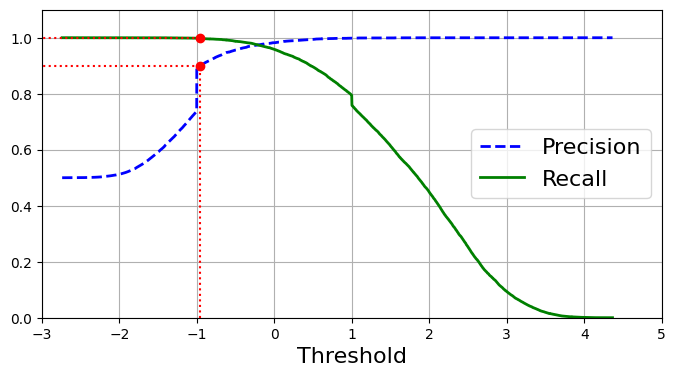

In [28]:
import numpy as np

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-3, 5, 0, 1.1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-5, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-5, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")       
  # Not shown
# save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

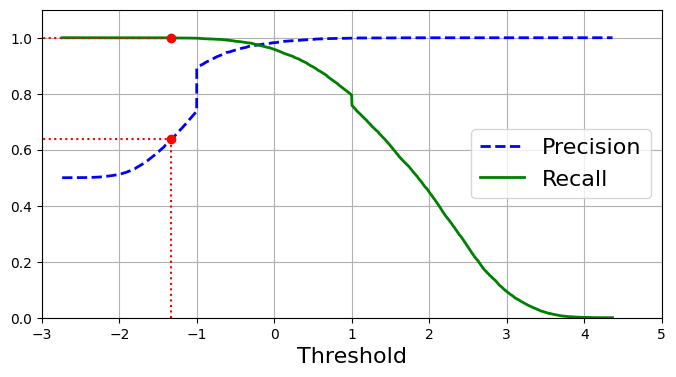

In [32]:
precision_n1_threshold = precisions[np.argmax(thresholds > -1.3279065)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([-1.3279065, -1.3279065], [0., precision_n1_threshold], "r:")                 # Not shown
plt.plot([-5, -1.3279065], [precision_n1_threshold, precision_n1_threshold], "r:")                                # Not shown
plt.plot([-5, -1.3279065], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([-1.3279065], [precision_n1_threshold], "ro")                                             # Not shown
plt.plot([-1.3279065], [recall_90_precision], "ro")

plt.show()

In [33]:
precision_n1_threshold

0.6370397917441428

In [15]:
threshold_90_precision

-0.9539949678752517

In [8]:
recall_90_precision

0.9973333333333333

In [55]:
thresholds[np.argmax(thresholds > -1.3279065)]

-1.3278507372540216

In [46]:
im = full_pipeline.fit_transform(X_test)

y_scores = svm_model.decision_function(im)
# y_scores

threshold = threshold_90_precision
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False,  True,  True, ..., False,  True, False])

In [56]:
threshold = thresholds[np.argmax(thresholds > -1.3279065)]
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True,  True,  True, ...,  True,  True, False])

In [131]:
y_test_t_f = y_test == 'Positive'

In [57]:
y_test = joblib.load( '/kaggle/input/y-test/y_test_concrete_crack.pkl')
print(np.array(y_some_digit_pred == y_test_t_f)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_some_digit_pred == y_test_t_f)/len(y_test_t_f))

[False  True False False  True False  True  True  True  True False  True
 False  True False  True  True  True  True  True  True  True  True  True
 False]

Percentage correct:  70.98333333333333


In [132]:
threshold = threshold_90_precision
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

print(np.array(y_some_digit_pred == y_test_t_f)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_some_digit_pred == y_test_t_f)/len(y_test_t_f))

/tmp/ipykernel_32/4241149073.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.array(y_some_digit_pred == y_test_t_f)[:25])


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [80]:
X_test[0]

array([[[0.52099178, 0.45040354, 0.39550158],
        [0.55768981, 0.48710148, 0.43219951],
        [0.51300383, 0.4416888 , 0.38678684],
        ...,
        [0.58647105, 0.51195419, 0.45307882],
        [0.55549737, 0.47701507, 0.41254824],
        [0.55917166, 0.46142076, 0.40114727]],

       [[0.48801675, 0.41742852, 0.36252656],
        [0.51974242, 0.44915408, 0.39425212],
        [0.49437036, 0.42305533, 0.36815337],
        ...,
        [0.55008966, 0.47456435, 0.4154642 ],
        [0.5755092 , 0.49711555, 0.43220549],
        [0.54574565, 0.45719005, 0.39356486]],

       [[0.46375862, 0.39317038, 0.33826842],
        [0.52838202, 0.45779369, 0.40289172],
        [0.49475537, 0.42344034, 0.36853838],
        ...,
        [0.54357996, 0.45964419, 0.39861691],
        [0.60881107, 0.52668163, 0.46008289],
        [0.55728499, 0.47566825, 0.40908366]],

       ...,

       [[0.531321  , 0.46073276, 0.4058308 ],
        [0.50093433, 0.43034609, 0.37545168],
        [0.47283417, 0

In [133]:
#svc_model = SVC()
#svc_model.fit(train_trans_data, y_train)

im = imread("/kaggle/input/image33/SPR-is-this-the-best-way-to-repair-concrete-cracks-844642-hero-4e0ba4c70ede44789fe41e4987fd430e.jpg")
im = resize(im, (80, 80))
im2 = imread("/kaggle/input/image33/cracking-in-concrete.jpg")
im2 = resize(im2, (80, 80))
im3 = imread("/kaggle/input/concrete-and-pavement-crack-images/Negative/00006.jpg")
im3 = resize(im3, (80, 80))
im4 = imread("/kaggle/input/image33/istockphoto-533964623-612x612.jpg")
im4 = resize(im4, (80, 80))

i = full_pipeline.fit_transform( X_test)#[0],X_test[5900], im, im2, im3, im4])

y_scores = svc_model.decision_function(i)
# y_scores

threshold = threshold_90_precision#thresholds[np.argmax(thresholds > -1.3279065)]
y_some_digit_pred = (y_scores > 0)
y_some_digit_pred

array([False,  True,  True, ..., False,  True, False])

In [134]:
print(np.array(y_some_digit_pred == y_test_t_f)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_some_digit_pred == y_test_t_f)/len(y_test_t_f))

[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  97.33333333333333


In [125]:
y_scores

array([-0.30587128,  2.81033029,  1.58955674,  2.39214239, -0.49031099,
       -0.90053303])

In [102]:
threshold_90_precision

-0.9539949678752517

In [94]:
i = full_pipeline.fit_transform(np.array(im))

y_scores = svc_model.decision_function(i)
# y_scores

threshold = thresholds[np.argmax(thresholds > -1.3279065)]
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

ValueError: negative dimensions are not allowed

In [93]:
y_scores

array([0.40682758, 1.67542798, 0.9527523 ])

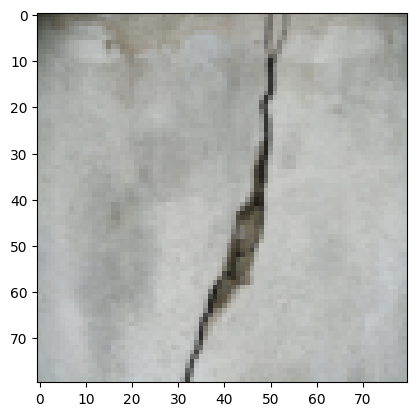

In [128]:
#labels = np.unique(data['label'])



plt.imshow(im2)
    


In [ ]:
# from IPython.display import FileLink
# FileLink(r'/kaggle/working/svc_cassif_concrete_crack.pkl')

In [ ]:
# cross_val_score(svc_model, train_trans_data, y_train, cv=3, scoring="accuracy")

In [ ]:
# sgd =  SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
# linear_model = LogisticRegression()
# svc_model = SVC(probability=True)
# ranf_model = RandomForestClassifier(random_state=42, n_jobs=-1
#                                        , max_leaf_nodes=8 , n_estimators=250)

# voting_cfr = VotingClassifier(
# estimators=[('ranf_model', ranf_model), ('svc_model', svc_model), ('sgd', sgd)],
#     voting='soft'
# )
# voting_cfr.fit(train_trans_data, y_train)
# joblib.dump(trans_data, 'voting_cfr_concrete_crack.pkl')

In [ ]:
# y_pred = ranf_model.predict(test_trans_data)

# print(np.array(y_pred[0] == y_test)[:25])
# print('')
# print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

In [6]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import skimage
import numpy as np
from sklearn.svm import SVC

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
import joblib

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):

        return np.array([skimage.color.rgb2gray(img) for img in X])

class HogTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, y=None, pixels_per_cell=(8, 8),
                cells_per_block=(3, 3)):
        self.y = y
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        try: # parallel
            return np.array([hog(img, pixels_per_cell=self.pixels_per_cell,
    cells_per_block=self.cells_per_block) for img in X])
        except:
            return np.array([hog(img, pixels_per_cell=self.pixels_per_cell,
    cells_per_block=self.cells_per_block) for img in X])



# model = pickle.load(open('model.pkl','rb'))

train_trans_data = joblib.load("/kaggle/input/trans-data/trans_data_concrete_crack.pkl")
y_train = joblib.load("/kaggle/input/y-train/y_train_concrete_crack.pkl")
svc_model = SVC()
svc_model.fit(train_trans_data, y_train)
joblib.dump(svc_model, 'svc_model_concrete_crack.pkl')

pipeline = joblib.load("/kaggle/input/pipeline/pipeline.pkl")
# model = joblib.load("/kaggle/input/svm-cfa/svc_cassif_concrete_crack.pkl")
    
    # input_query = np.array([[cgpa,iq,profile_score]])
    # result = model.predict(input_query)[0]

    # im = imread("istockphoto-533964623-612x612.jpg")
    # im = resize(imread("istockphoto-533964623-612x612.jpg"), (80, 80))


    


FileNotFoundError: No such file: '/kaggle/input/image33/istockphoto-533964623-612x612.jpg.jpg'

In [28]:
im = imread("/kaggle/input/image33/SPR-is-this-the-best-way-to-repair-concrete-cracks-844642-hero-4e0ba4c70ede44789fe41e4987fd430e.jpg")
im = resize(im, (80, 80))
im2 = imread("/kaggle/input/image33/cracking-in-concrete.jpg")
im2 = resize(im2, (80, 80))
im3 = imread("/kaggle/input/concrete-and-pavement-crack-images/Negative/00006.jpg")
im3 = resize(im3, (80, 80))
im4 = imread("/kaggle/input/image33/istockphoto-533964623-612x612.jpg")
im4 = resize(im4, (80, 80))
im5 = imread("/kaggle/input/concrete-and-pavement-crack-images/Negative/00003.jpg")
im5 = resize(im4, (80, 80))
im6 = imread("/kaggle/input/concrete-and-pavement-crack-images/Positive/00006.jpg")
im6 = resize(im6, (80, 80))

i = pipeline.fit_transform(np.array([im, im2, im3, im4, im5, im6]))
result = svc_model.decision_function(i)

print(result)

y_pred = (result < 0)


[ 1.98472186  2.50432891  0.09331474 -1.39283621 -1.39283621  1.26045694]
